# lesson5
## search Tree --> Similar words

In [1]:
import pandas as pd
csv_path = 'D:/code_project/data/lesson5/test.csv'
content = pd.read_csv(csv_path, encoding='utf8')
content = content.fillna('') #fillna函数的作用是填充缺失值
news_content = content['content'].tolist()


In [2]:
import jieba 
import re

def cut(string):
    words = jieba.cut(string)
    return ' '.join(words)

def token(string): #找出所需要的内容
    return re.findall(r'[\d|\w]+', string)


In [3]:
token('this is 一个测试\n\n\n')

['this', 'is', '一个测试']

In [4]:
news_content = [token(n) for n in news_content]  #删除非文本和数字的字符
news_content = [' '.join(n) for n in news_content] #把子数组变成字符串，并用空格隔开
news_content = [cut(n) for n in news_content]  #分词

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HSUHUI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.673 seconds.
Prefix dict has been built succesfully.


In [5]:
news_content[0]

'今天 我 买 了 一件 新 衣服'

In [8]:
import codecs
f = codecs.open('D:/code_project/data/lesson5/new_sentence_cut.txt', 'w', encoding='utf-8')
for n in news_content:
    f.write(n)
    f.write(u'\r\n')


In [9]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing
infile = 'D:/code_project/data/lesson5/new_sentence_cut.txt'
model1 =  Word2Vec(LineSentence(infile), size=30, window=5, min_count=1,
                   workers=multiprocessing.cpu_count(), iter=20)


In [10]:
model1.most_similar(u'水杯', topn=2)

D:\xuhui\program64\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('来自', 0.5752336978912354), ('我', 0.19574882090091705)]

### 由于语料库词汇少，所以构建的模型效果不好。下面的任务将使用lesson4中维基百科语料库训练好的模型来进行实验
## 任务：输入一个词，搜索与该词相关的词

In [12]:
import gensim
model = gensim.models.Word2Vec.load('D:\code_project\data\wiki_corpus\model_generate\wiki.zh.text.model')

In [15]:
model.most_similar(u'中国',topn=10)

D:\xuhui\program64\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('我国', 0.5835405588150024),
 ('中国政府', 0.5347201228141785),
 ('中华人民共和国', 0.532524824142456),
 ('欧美', 0.5277433395385742),
 ('境外', 0.519973874092102),
 ('外国', 0.4999949634075165),
 ('北京', 0.49076908826828003),
 ('中华人民共和国政府', 0.49053075909614563),
 ('东亚', 0.48363959789276123),
 ('国外', 0.4718197286128998)]

In [ ]:
from collections import defaultdict

def get_related_words(initial_words, model=model):
    """
     :initials_wards: the word we already know
     :model: the word2vec model
    """
    
    unseen = initial_words
    seen = defaultdict(int)
    max_size = 50
    while unseen and len(seen) < max_size:
        if len(seen)%1 == 0:
            print('seen length : {}'.format(len(seen)))
            
            node = unseen.pop(0)
            new_expanding = [w for w,s in model.most_similar(node, topn=5)]
            unseen += new_expanding
            seen[node] += 1
    # optimal: 1. score function could be revised
    # optimal: 2. using dymanic programming to reduce computing time
    return seen

In [ ]:
len(model.wv.vocab)

In [ ]:
related_words = get_related_words([u'中国',u'北京'],model)
sorted(related_words.items(), key=lambda x:x[1], reverse=True)

# TFIDF Key words

In [13]:
news_content[0]

'今天 我 买 了 一件 新 衣服'

In [21]:
import math
def tf(word, ducument):
    """
    get the term frequency of the @word in the @ducument
    """
    words = ducument.split()
    return sum(1 for w in words if w==word)

def idf(word, document_set):
    """
    get the inverse ducument frequency
    """
    number_of_total_document = len(document_set)
    number_of_related_document = sum(1 for doc in document_set if word in doc)
    return math.log10(number_of_total_document / number_of_related_document)
    


In [22]:
def get_keywords_of_a_document(document, document_set):
    words = set(document.split())
    tfidf = [(w, tf(w,document)*idf(w,document_set)) for w in words]
    return sorted(tfidf, key=lambda x:x[1], reverse=True) # reverse=True降序, reverse=False升序(默认)
    

In [24]:
news_keywords = get_keywords_of_a_document(news_content[0], news_content)
news_keywords

[('今天', 0.6020599913279624),
 ('了', 0.6020599913279624),
 ('衣服', 0.6020599913279624),
 ('新', 0.6020599913279624),
 ('一件', 0.6020599913279624),
 ('买', 0.3010299956639812),
 ('我', 0.12493873660829993)]

# WordCloud

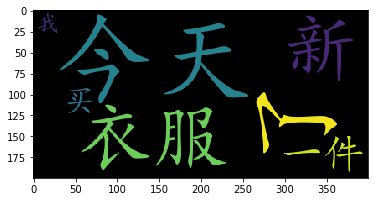

In [27]:
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
news_words_dict = defaultdict(None)
news_words_dict.update({w:score for w,score in news_keywords})

wc = wordcloud.WordCloud(font_path='C:/Windows/Fonts/simkai.ttf')
wc.generate_from_frequencies(news_words_dict)

plt.figure(1)
plt.imshow(wc)

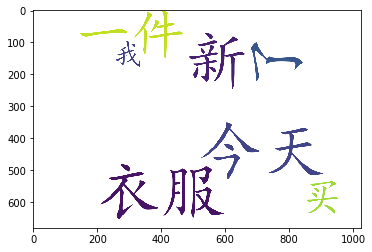

In [32]:
from PIL import Image
import numpy as np
mask_of_this_wc = np.array(Image.open('D:/code_project/data/wordcloudData/xila_scenery.jpg'))
wc_with_mask = wordcloud.WordCloud(background_color='white',
                                   font_path='C:/Windows/Fonts/simkai.ttf',
                                   mask=mask_of_this_wc)
wc_with_mask.generate_from_frequencies(news_words_dict)
plt.figure(2)
plt.imshow(wc_with_mask)

# TFIDF Vectorizer (tdodf 矢量化程序）

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorized = TfidfVectorizer(max_features=1000)
tfidf_of_document = vectorized.fit_transform(news_content)
print(tfidf_of_document.toarray())
print(tfidf_of_document.shape)
print(vectorized.vocabulary_)

[[0.         0.57735027 0.         0.57735027 0.         0.
  0.         0.         0.         0.         0.57735027]
 [0.         0.         0.         0.         0.70710678 0.
  0.         0.         0.70710678 0.         0.        ]
 [0.         0.         0.57735027 0.         0.         0.57735027
  0.         0.57735027 0.         0.         0.        ]
 [0.57735027 0.         0.         0.         0.         0.
  0.57735027 0.         0.         0.57735027 0.        ]]
(4, 11)
{'今天': 3, '一件': 1, '衣服': 10, '来自': 8, '北京大学': 4, '天气': 5, '晴朗': 7, '一天': 2, '水杯': 9, '好看': 6, '一个': 0}


### 文本相似度分析

In [59]:
import random
from scipy.spatial.distance import cosine

def distance(v1, v2):
    return cosine(v1, v2)
ducument_array = tfidf_of_document.toarray()
document_need_check = ducument_array[0]
distance_list = [(i,distance(ducument_array[i], document_need_check)) for i in range(len(ducument_array))]
print(distance_list)
sorted(distance_list, key=lambda x:x[1], reverse=True)


[(0, 0.0), (1, 1.0), (2, 1.0), (3, 1.0)]


[(1, 1.0), (2, 1.0), (3, 1.0), (0, 0.0)]

# Build search engine (搜索引擎)

In [63]:
def naive_search(keywords):
    keywords = keywords.split()
    news_ids = [i for i,cont in enumerate(news_content) if all(w in cont for w in keywords)]
    return news_ids

In [69]:
#%%timeit
naive_search('天气 晴朗')

[2]

### input word --> which document contain this word

# PageRank